### Import lib

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

### Activation Function

In [48]:
def softmax(z):
    z_exp = np.exp(z)
    z_sum = z_exp.sum(axis=0, keepdims=True)
    return z_exp / z_sum
    
def relu(z):
    return np.maximum(0, z)

def leaky_relu(z, alpha=0.01):
    return np.where(z > 0, z, alpha * z)

def tanh(z):
    return np.tanh(z)

def elu(z, alpha=1.0):
    return np.where(z > 0, z, alpha * (np.exp(z) - 1))

def selu(z, lambda_=1.0507, alpha=1.67326):
    return lambda_ * np.where(z > 0, z, alpha * (np.exp(z) - 1))


### Dense Layer

In [49]:
def dense_layer(inputs, weights, bias, activation=None):
    outputs = inputs @ weights + bias
    if activation == 'relu':
        outputs = relu(outputs)
    elif activation == 'tanh':
        outputs = tanh(outputs)
    elif activation == 'leaky_relu':
        outputs = leaky_relu(outputs)
    elif activation == 'elu':
        outputs = elu(outputs)
    elif activation == 'selu':
        outputs = selu(outputs)
    elif activation == 'softmax':
        outputs = softmax(outputs)
    return outputs

### Parameter Initializtion

In [50]:
def initialize_parameters(layer_dims):
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)
    for l in range(1, L):
        parameters[f"W{l}"] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2. / layer_dims[l-1])
        parameters[f"b{l}"] = np.zeros((layer_dims[l], 1))
    return parameters

### Dropout

In [51]:
def dropout(A, keep_prob):
    D = np.random.rand(*A.shape) < keep_prob
    A = np.multiply(A, D)
    A /= keep_prob
    return A, D

### Multilayer Network

In [52]:
def multilayer_network(X, parameters, activations, keep_prob=1.0):
    caches = []
    A = X
    L = len(parameters) // 2
    for l in range(1, L):
        A_prev = A
        W = parameters[f"W{l}"]
        b = parameters[f"b{l}"]
        Z = W@A_prev + b
        if activations[l-1] == 'relu':
            A = relu(Z)
        elif activations[l-1] == 'tanh':
            A = tanh(Z)
        elif activations[l-1] == 'leaky_relu':
            A = leaky_relu(Z)
        elif activations[l-1] == 'elu':
            A = elu(Z)
        elif activations[l-1] == 'selu':
            A = selu(Z)
        if keep_prob < 1.0:
            A, D = dropout(A, keep_prob)
            caches.append((A_prev, W, b, Z, D))
        else:
            caches.append((A_prev, W, b, Z))
    WL = parameters[f"W{L}"]
    bL = parameters[f"b{L}"]
    ZL = WL@A + bL
    AL = softmax(ZL)
    caches.append((A, WL, bL, ZL))
    return AL, caches

In [53]:
def to_categorical(labels):
    """
    Convert integers into one-hot vectors.
    
    Arguments:
    labels - vector of integers from 0 to C-1
    
    Returns:
    one_hot - matrix of shape (labels.size, C) with a one-hot encoded row for each element of 'labels'
    """
    
    # Number of elements in 'labels'
    size = labels.size
    
    # One plus the max value in 'labels'
    C = labels.max() + 1 
    
    # Create a zero matrix with the right shape
    one_hot = np.zeros((size, C), dtype=int)
    
    # Set the value 1 in the right positions
    idx1 = np.arange(size) 
    idx2 = labels.astype(int)
    one_hot[idx1, idx2] = 1
    
    return one_hot

### Backpropagation

In [54]:
def backpropagation(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = Y.shape[1]
    Y = Y.reshape(AL.shape)

    # Derivative of cross-entropy loss w.r.t. AL
    dAL = AL - Y

    # Backpropagation for the output layer
    current_cache = caches[-1]
    A_prev, W, b, Z = current_cache[:4]
    grads[f"dW{L}"] = np.dot(dAL, A_prev.T) / m
    grads[f"db{L}"] = np.sum(dAL, axis=1, keepdims=True) / m
    grads[f"dA{L-1}"] = np.dot(W.T, dAL)

    # Backpropagation for hidden layers
    for l in reversed(range(1, L)):
        current_cache = caches[l-1]
        A_prev, W, b, Z = current_cache[:4]
        dA = grads[f"dA{l}"]
        dZ = dA * (Z > 0)  # Derivative for ReLU
        grads[f"dW{l}"] = np.dot(dZ, A_prev.T) / m
        grads[f"db{l}"] = np.sum(dZ, axis=1, keepdims=True) / m
        if l > 1:
            grads[f"dA{l-1}"] = np.dot(W.T, dZ)

    return grads


### clip_gradients

In [55]:
def clip_gradients(grads, max_value=5.0):
    for key in grads.keys():
        np.clip(grads[key], -max_value, max_value, out=grads[key])
    return grads

### Stochastic Optimization Problem

In [56]:
class StochasticOptimizationProblem:
    def __init__(self, X, Y, batch_size):
        self.X = X
        self.Y = Y
        self.batch_size = batch_size
        self.total_samples = X.shape[1]
        self.num_batches = self.total_samples // batch_size
        self.current_batch = 0
    def shuffle_data(self):
        permutation = np.random.permutation(self.total_samples)
        self.X = self.X[:, permutation]
        self.Y = self.Y[:, permutation]
    def get_next_batch(self):
        start = self.current_batch * self.batch_size
        end = start + self.batch_size
        self.current_batch = (self.current_batch + 1) % self.num_batches
        return self.X[:, start:end], self.Y[:, start:end]
    def compute_cost(self, AL, Y):
        epsilon = 1e-8  # Small constant to prevent log(0)
        m = Y.shape[1]
        cost = -np.sum(Y * np.log(AL + epsilon)) / m
        return cost
    def reset(self):
        self.current_batch = 0
        self.shuffle_data()

### Stochastic Training

In [57]:
def stochastic_training(problem, parameters, activations, num_epochs, learning_rate, keep_prob=1.0):
    losses = []  # Track loss for visualization

    for epoch in range(num_epochs):
        problem.reset()
        epoch_cost = 0
        for batch in range(problem.num_batches):
            X_batch, Y_batch = problem.get_next_batch()
            AL, caches = multilayer_network(X_batch, parameters, activations, keep_prob)
            batch_cost = problem.compute_cost(AL, Y_batch)
            epoch_cost += batch_cost

            # Backpropagation
            grads = backpropagation(AL, Y_batch, caches)
            grads = clip_gradients(grads)  # Apply gradient clipping
            for l in range(1, len(parameters) // 2 + 1):
                parameters[f"W{l}"] -= learning_rate * grads[f"dW{l}"]
                parameters[f"b{l}"] -= learning_rate * grads[f"db{l}"]

        avg_cost = epoch_cost / problem.num_batches
        losses.append(avg_cost)  # Record average cost for this epoch
        print(f"Epoch {epoch + 1}/{num_epochs}, Cost: {avg_cost:.4f}")

    return parameters, losses

### Handwritten Digits Recognition

In [58]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, Y = mnist.data / 255.0, mnist.target
Y = Y.astype(int)  # Ensure labels are integers
encoder = OneHotEncoder(sparse_output=False)
Y = encoder.fit_transform(Y.reshape(-1, 1)).T
X = X.T

In [59]:
X_train, X_test, Y_train, Y_test = train_test_split(X.T, Y.T, test_size=0.2, random_state=42)
X_train, X_test = X_train.T, X_test.T
Y_train, Y_test = Y_train.T, Y_test.T

### Define and Train Network

In [60]:
layer_dims = [784, 128, 64, 10]
parameters = initialize_parameters(layer_dims)
problem = StochasticOptimizationProblem(X_train, Y_train, batch_size=64)
activations = ['relu', 'leaky_relu', 'softmax']
trained_parameters, losses = stochastic_training(problem, parameters, activations, num_epochs=10, learning_rate=0.4)

Epoch 1/10, Cost: 0.2665
Epoch 2/10, Cost: 0.1053
Epoch 3/10, Cost: 0.0750
Epoch 4/10, Cost: 0.0590
Epoch 5/10, Cost: 0.0458
Epoch 6/10, Cost: 0.0367
Epoch 7/10, Cost: 0.0295
Epoch 8/10, Cost: 0.0267
Epoch 9/10, Cost: 0.0187
Epoch 10/10, Cost: 0.0171


### Evaluate Network

In [61]:
# Calculate training accuracy
AL_train, _ = multilayer_network(X_train, trained_parameters, activations)
train_predictions = np.argmax(AL_train, axis=0)
train_true_labels = np.argmax(Y_train, axis=0)
train_accuracy = np.mean(train_predictions == train_true_labels)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

Training Accuracy: 99.42%


In [62]:
# Calculate test accuracy
AL_test, _ = multilayer_network(X_test, trained_parameters, activations)
predictions = np.argmax(AL_test, axis=0)
true_labels = np.argmax(Y_test, axis=0)
accuracy = np.mean(predictions == true_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 97.45%


### Visualizations

#### 1. Training Loss Curve

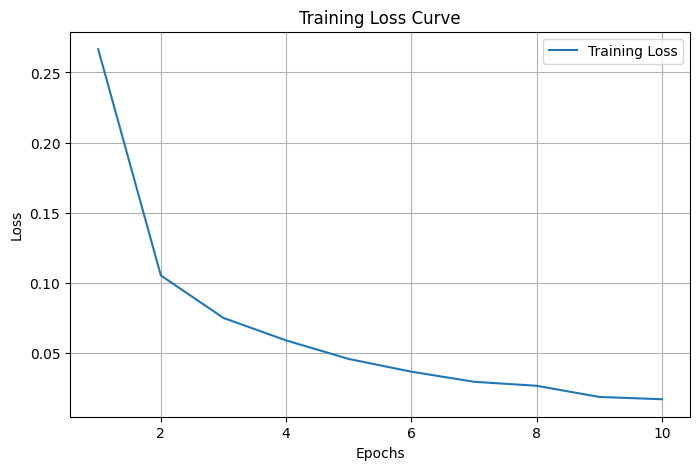

In [63]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(losses) + 1), losses, label="Training Loss")
plt.title("Training Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

#### 2. Random Test Sample Predictions

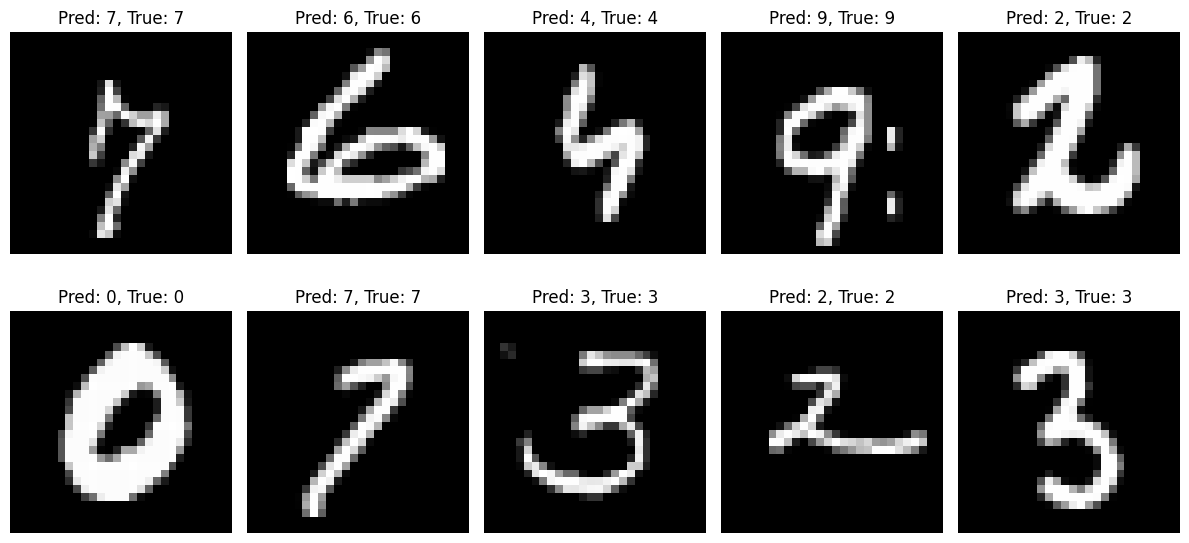

In [64]:
indices = np.random.choice(X_test.shape[1], 10, replace=False)  # Select 10 random test samples
plt.figure(figsize=(12, 6))

for i, idx in enumerate(indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[:, idx].reshape(28, 28), cmap="gray")
    plt.title(f"Pred: {predictions[idx]}, True: {true_labels[idx]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

#### Prediction Function

In [65]:
def prediction(X, parameters, activations):
    """
    Predict the labels for input X using trained parameters.

    Arguments:
    X -- Input data of shape (N, 784), where N is the number of samples.
    parameters -- Trained parameters of the neural network.
    activations -- List of activation functions for each layer.

    Returns:
    Predicted labels for the input data.
    """
    X = X.T  # Transpose to shape (784, N)
    AL, _ = multilayer_network(X, parameters, activations)  # Forward pass

    if AL.ndim != 2 or AL.shape[0] != 10:  # Ensure AL has the correct shape
        raise ValueError(f"Unexpected shape for AL: {AL.shape}. Expected (10, N).")

    return np.argmax(AL, axis=0)  # Return the index of the highest probability


**Preprocess a list of digit images, and run the network on them to predict their classes.**

In [66]:
import cv2
from data.digits import find_digits

def digit_recognition(image_name):
    # Load and preprocess the image
    image = cv2.imread(image_name)
    if image is None:
        print("Error loading image!")
        return

    digits, rects = find_digits(image)  # Detect digits and bounding boxes

    # Preprocess digits
    digits = np.array([cv2.resize(digit, (28, 28)).flatten() for digit in digits])
    digits = digits.astype('float32') / 255.0  # Normalize

    print("Preprocessed digits shape:", digits.shape)  # Debug: check shape

    # Predict digit labels
    activations = ['relu', 'relu', 'softmax']
    labels = prediction(digits, trained_parameters, activations)

    # Draw bounding boxes and labels on the image
    for tag, rect in zip(labels, rects):
        cv2.rectangle(image, (rect[0], rect[1]), (rect[0] + rect[2], rect[1] + rect[3]), (0, 255, 0), 3)
        cv2.putText(image, str(tag), (rect[0], rect[1] - 5), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255, 0, 0), 3)

    # Show the image
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()



Preprocessed digits shape: (8, 784)


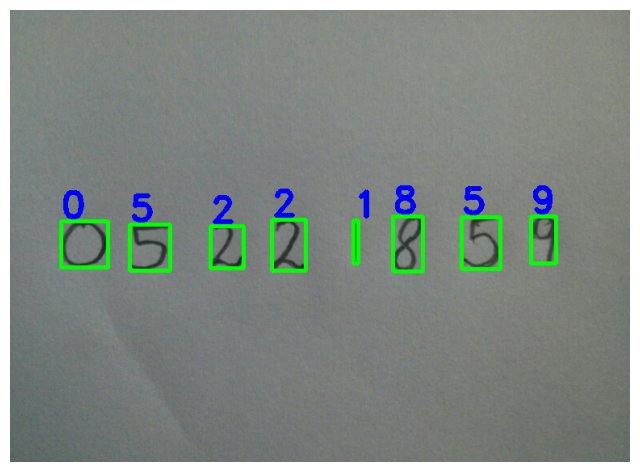

In [67]:
digit_recognition("data/photo1.jpg")

Preprocessed digits shape: (24, 784)


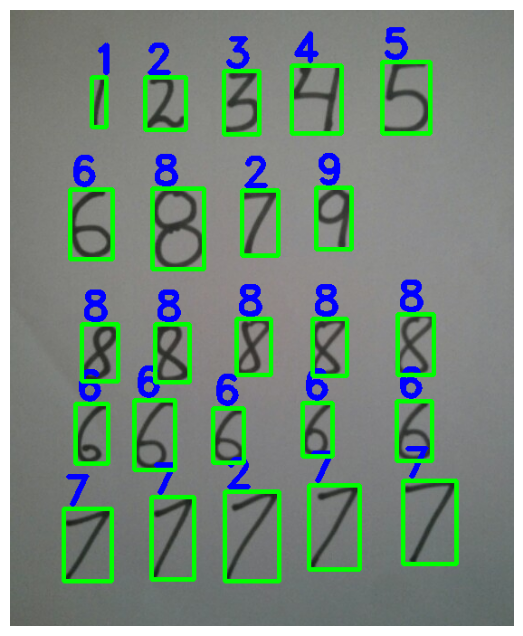

In [68]:
digit_recognition("data/photo2.jpg")

Preprocessed digits shape:

 (24, 784)


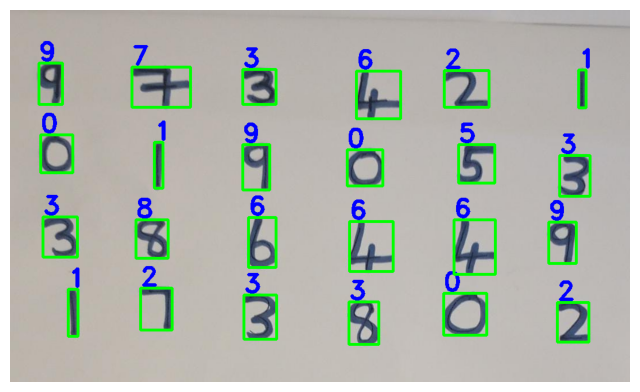

In [69]:
digit_recognition("data/photo3.jpg")